<a href="https://colab.research.google.com/github/YonghaoCode/YonghaoCode/blob/main/problem_gr5242_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GR5242 HW01 Problem 1: Basics**

**Instructions**: This problem is an individual assignment -- you are to complete this problem on your own, without conferring with your classmates.  You should submit a completed and published notebook to Courseworks; no other files will be accepted.

**Description**: The goal of this problem is to get your familiar with neural network training from end to end.

Our main tool is `torch`, especially [`torch.nn`](https://pytorch.org/docs/stable/nn.html) and [`torch.optim`](https://pytorch.org/docs/stable/optim.html), that helps us with model building and automatic differentiation / backpropagation.

There are 4 questions in this notebook, including 3 coding quesitons and 1 text question. Each coding question expects 1~3 lines of codes, and the text question expects just 1 sentence of explanation.

In [1]:
# PyTorch imports:
#
# torch is the base package, nn gives nice classes for Neural Networks,
# F contains our ReLU function, optim gives our SG method,
# DataLoader allows us to do batches efficiently,
# and torchvision is for downloading MNIST data directly from PyTorch
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.5.0+cu121


## Dataset

We will working on `mnist` dataset, which contain images of written digits of 0-9 and corresponding labels.

We have it set up to download the data directly from the `torch` library.

In [2]:
# First, we will define a way of transforming the dataset automatically
# upon downloading from pytorch

# first convert an image to a tensor and then scale its values to be between -1 and 1, which can be beneficial for training certain neural networks
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

# Next, we fetch the data

mnist_train = datasets.MNIST(root='./data', train=True,
                             download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False,
                             download=True, transform=transform)

# and define our DataLoaders

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader  = DataLoader(mnist_test,  batch_size=32, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 538kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.77MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.72MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Each image is represented as a 28x28 matrix of pixel values, and each label is the corresponding digit.

Let's show an image of a random one! Try running the below cell a few times to see different examples and how the DataLoaders will be shuffling batches.

Note: Why is this random, when there is no random code in the next cell? The randomness comes from `shuffle=True` in the `train_loader`!

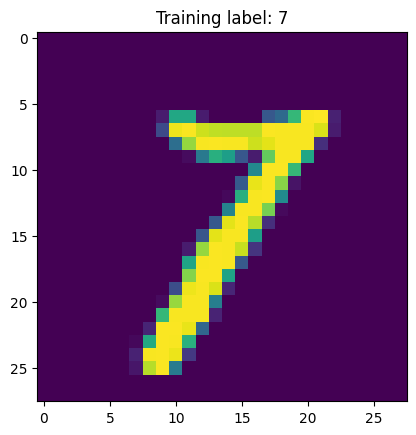

In [3]:
inputs, classes = next(iter(train_loader))

plt.imshow(inputs[23].squeeze())
plt.title('Training label: '+str(classes[23].item()))
plt.show()

Let's now show 25 of them in black and white:

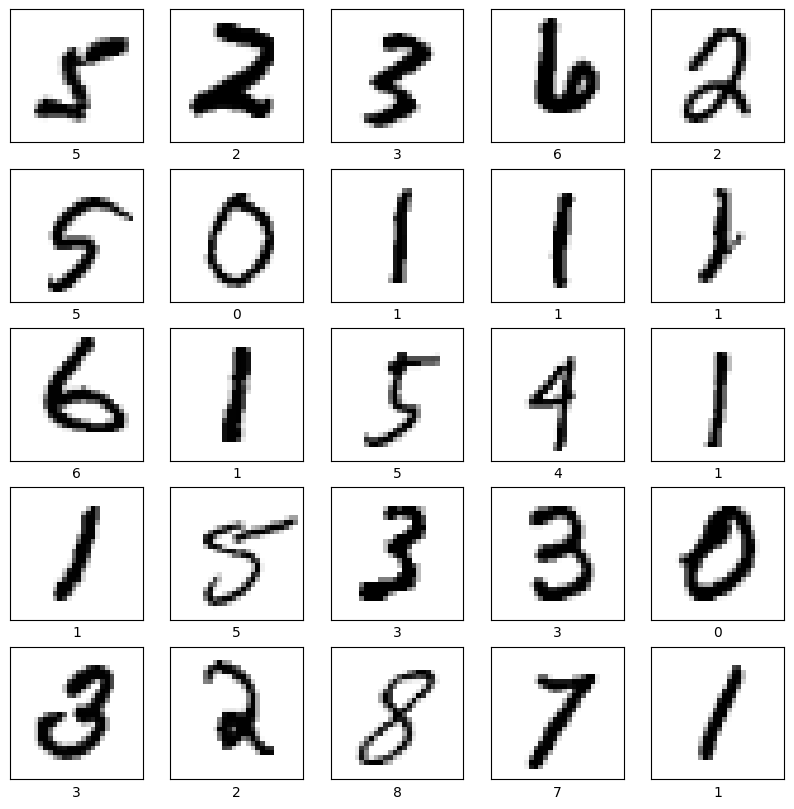

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(inputs[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(classes[i].item())
plt.show()

By printing out the shapes, we see there are 60,000 training data and 10,000 test data. Each image is represented as a 28x28 matrix of pixel values, and each label is the corresponding digit.

In [5]:
# For training data
train_data_example, train_label_example = mnist_train[0]
print("Shape of a single training image:", train_data_example.shape)

# For test data
test_data_example, test_label_example = mnist_test[0]
print("Shape of a single test image:", test_data_example.shape)

# The total number of images in each dataset
print("Total number of training images:", len(mnist_train))
print("Total number of test images:", len(mnist_test))


Shape of a single training image: torch.Size([1, 28, 28])
Shape of a single test image: torch.Size([1, 28, 28])
Total number of training images: 60000
Total number of test images: 10000


## Recap of classification task

In a classification task with $K$ classes, suppose the predicted logits for an image are $s_1, \cdots, s_K$. The predicted probabilities are then

$$\hat p_i = \frac{\exp \{ s_i\}}{\sum_{j=1}^K \exp \{s_j\}}, \text{ for }i=1:K$$

The CrossEntropy (CE) loss is defined as

$$CE = - \sum_{i=1}^K t_i \log (\hat p_i)$$

where $t_i=1$ if the image belongs to the $i$th class or otherwise $t_i=0$.

## Model

Now, we will build a model to predict the logits of images for the classificaiton task.

### Question 1: Building the Model

In the following, we will write a class for a basic one-hidden-layer, ReLU, feedforward network. There are a few components to a model in Pytorch, and we will break them down step by step.

First, we need to define the class. As with any class definition, we start with an `__init__` method. Since Pytorch provides us with many useful features within the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, we will use inheritence to pass these down to our `Net` class. This involves putting nn.Module inside the parenthesis in the class definition, and a `super().__init__()` call in the `__init__()` method.

Within the initialization, we then define two layers: one hidden layer with 128 neurons, and one output layer with `10` class logits. The hidden layer should take an input of size `28 x 28` and give an output of size `128`, while the output layer takes input of size `128` and gives output of size `10`. It is suggested to use the [`nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) object to accomplish this, which applies a transformation $z = x W^T + b$.

Next, we define a special method called `forward(),` which defines how data propagate through the model. This method will be called either by `model.forward(x)` or by `model(x)`, and is where Pytorch looks for the information for its automatic derivative computation capabilities.

In the forward method, we first will reshape our image `img` using `img.view()`.

Then, we will apply the hidden layer (the one we defined) and the ReLU function `F.relu`.

Finally, we apply the output layer and return our output. Importantly, do not apply SoftMax to the output just yet. We will handle that part later

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(28*28, 128)  # 784 inputs to 128 neurons
        self.output_layer = nn.Linear(128, 10)  # 128 inputs to 10 class logits
        ### YOUR CODE HERE ###

    def forward(self, img):
        x = img.view(-1, 28*28) # reshape the image to be a single row
        # pass x through both layers, with ReLU in between
        x = F.relu(self.hidden_layer(x))  # Apply ReLU activation
        x = self.output_layer(x)  # Output logits

        ######################
        return x

model = Net()

### Question 2: Defining the Loss and Optimizer

When training a `torch` model, typically you need to specify the following two items:

- optimizer: specifies a way to apply gradient descent update of model parameters. We will use the [`optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer with a learning rate of 0.001 in this example.

- loss_fn: the objective function to minimize over. In classification task, the cross-entropy loss is used.

Please fill in the `optimizer` with an appropriate learning rate `lr`, and choose an appropriate number of `epochs` (number of passes through the data) in the following code.

Note: remember that the neural network outputs the `logits` instead of the class probabilities (why? answer the question below), and make sure to specify this in the `loss function`.


In [7]:
loss_fn = nn.CrossEntropyLoss()
### YOUR CODE HERE ###
optimizer = optim.Adam(model.parameters(), lr=0.001)
######################



### Question 3: The neural network specified above does not output class probabilities, because the last layer of the neural network is a linear layer which outputs value ranging from $(-\infty, \infty)$.  Your choice of loss function above should take care of that, but what _mathematical_ function maps these logit values to class probabilities?

#######################
###### YOUR ANSWER HERE




#######################

Softmax Function
The Softmax function maps logits (values in the range
(
−
∞
,
∞
)
(−∞,∞)) to class probabilities. For
𝐾
K classes, the probability for class
𝑖
i is calculated as:

𝑝
𝑖
=
exp
⁡
(
𝑠
𝑖
)
∑
𝑗
=
1
𝐾
exp
⁡
(
𝑠
𝑗
)
p
i
​
 =
∑
j=1
K
​
 exp(s
j
​
 )
exp(s
i
​
 )
​

Where:

𝑠
𝑖
s
i
​
  is the logit value for class
𝑖
i,
exp
⁡
(
𝑠
𝑖
)
exp(s
i
​
 ) is the exponential of the logit,
∑
𝑗
=
1
𝐾
exp
⁡
(
𝑠
𝑗
)
∑
j=1
K
​
 exp(s
j
​
 ) is the sum of the exponentials of all logits.

### Softmax Function

The **Softmax function** maps logits (values in the range \( (-\infty, \infty) \)) to class probabilities. For \( K \) classes, the probability for class \( i \) is calculated as:

\[
p_i = \frac{\exp(s_i)}{\sum_{j=1}^{K} \exp(s_j)}
\]

Where:
- \( s_i \) is the logit value for class \( i \),
- \( \exp(s_i) \) is the exponential of the logit,
- \( \sum_{j=1}^{K} \exp(s_j) \) is the sum of the exponentials of all logits.

---

### Why Softmax is Not Applied Directly in the Model

The Softmax function is not applied directly in the last layer of the model because:
1. **Numerical Stability**: The `CrossEntropyLoss` function combines the Softmax operation and the negative log-likelihood calculation in a numerically stable way.
2. **Efficiency**: Avoids redundant computations during training.

Instead, the model outputs logits, which are passed directly to `CrossEntropyLoss`.

---

### Summary

The **Softmax function** is the mathematical operation that maps logits to class probabilities in classification tasks, ensuring that probabilities are non-negative and sum to 1.


## Training

Now let's train the model for your chosen number of epochs. By the end of the training, you should expect an accuracy above 0.98.

In each step, we need to:

1.) grab `x` and `y` from the batch (note that each batch is a tuple of `x` and `y`)

2.) zero the optimizer's gradients

3.) make a prediction `y_pred`

4.) call the `loss_fn` between `y` and `y_pred`

5.) backpropagate

6.) make the approprite step calculated by the `optimizer`

In [8]:
epochs = 10

for epoch in range(epochs):
    losses = []
    accuracies = []
    for batch in train_loader:
        x_batch, y_batch = batch
        optimizer.zero_grad()  # Zero the gradients
        y_pred = model(x_batch)  # Forward pass
        loss = loss_fn(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Calculate accuracy
        _, y_pred_labels = torch.max(y_pred, 1)
        correct = (y_pred_labels == y_batch).sum().item()
        total = y_batch.size(0)
        accuracies.append(correct / total)
        losses.append(loss.item())

    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(accuracies)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

Epoch 1/10, Loss: 0.3562, Accuracy: 0.8947
Epoch 2/10, Loss: 0.1776, Accuracy: 0.9463
Epoch 3/10, Loss: 0.1345, Accuracy: 0.9596
Epoch 4/10, Loss: 0.1113, Accuracy: 0.9659
Epoch 5/10, Loss: 0.0964, Accuracy: 0.9700
Epoch 6/10, Loss: 0.0868, Accuracy: 0.9726
Epoch 7/10, Loss: 0.0768, Accuracy: 0.9755
Epoch 8/10, Loss: 0.0722, Accuracy: 0.9764
Epoch 9/10, Loss: 0.0685, Accuracy: 0.9784
Epoch 10/10, Loss: 0.0616, Accuracy: 0.9800


## Test Evaluation

Finally, we evaluate our model on the test set. You could expect the test accuracy to be slightly lower than the training accuracy.

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:
        x_batch, y_batch = batch
        y_logit = model(x_batch)
        for index, output in enumerate(y_logit):
            y_pred = torch.argmax(output)
            if y_pred == y_batch[index]:
                correct += 1
            total += 1

print('testing accuracy:', correct/total)

testing accuracy: 0.9742


### Make Prediction

#### Question 4: fill in the following code block to estimate class probabilities and make predictions on test images. The results should be stored in `class_probabilities` and `predicted_labels`. Compare to the true labels, stored in `true_labels` by computing the accuracy. It should be the same as above.

#### (Hint: you can use much of the same structure from the cell above. You can use `F.softmax` to calculate probabilities from the logits, and store the results however you please.)

In [11]:
### YOUR CODE HERE ###

with torch.no_grad():
    class_probabilities = []
    predicted_labels = []
    true_labels = []

    for x_batch, y_batch in test_loader:
        y_logit = model(x_batch)  # Forward pass
        probabilities = F.softmax(y_logit, dim=1)  # Compute probabilities
        _, predictions = torch.max(probabilities, 1)  # Get predicted labels

        # Extend lists with NumPy arrays for compatibility
        class_probabilities.extend(probabilities.numpy())  # Convert to NumPy
        predicted_labels.extend(predictions.numpy())  # Convert to NumPy
        true_labels.extend(y_batch.numpy())  # Convert to NumPy

# Make sure true_labels and predicted_labels are NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

########################
print('accuracy verification: ', sum(true_labels==predicted_labels)/len(true_labels))

accuracy verification:  0.9742
